In [2]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as plt
import matplotlib as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils, zscores
from utils import plotting_utils as pu
from utils import auc_methods as am
import matplotlib.patches as patches
from matplotlib import gridspec
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

C:\Users\efink\Anaconda3\envs\crossmodal\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  # Remove the CWD from sys.path while we load stuff.


In [3]:
size_mult = 0.1
plt.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
mpl.rc('axes', labelsize=12)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [4]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

# Load data and prepare data
## Load behavior and spike data

In [5]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

In [6]:
unit_key_df.shape

(1539, 46)

### Remove any units that were recorded from tactile lick-left/visual lick-right mice

In [7]:
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
unit_key_df['mouse_name'].unique()

array(['EF0089', 'EF0114', 'EF0079', 'EF0074', 'EF0088', 'EF0077',
       'EF0084', 'EF0081', 'EF0076'], dtype=object)

In [8]:
def plot_raster(ax,ras,trial_total, window, bin_size = 0.025):
    """
    plot raster for a specific trial_type/outcome stacked on previous plotted raster
    """  
    spike_counts = []
    for trial, spike in enumerate(ras['spike_times(stim_aligned)']):
        spike = spike[(spike>window[0]) & (spike<=window[1])]
        ax.vlines(spike, trial + trial_total - .5, trial + trial_total +.5)
        ax.vlines(ras.iloc[trial]['first_lick'], trial + trial_total - .5, trial +
                   trial_total + .5, color = 'r', linewidth = 5)

        spike = spike[(spike>window[0]) & (spike<=window[1])]
        edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
        count, _ = np.histogram(spike,edges)
        spike_counts.append(count)
    return spike_counts

In [9]:
def plot_psth(spike_counts, ax, window, color, bin_size = 0.025):
    """
    plot psth corresponding to a raster
    """
    average_hist = np.mean(spike_counts, axis=0)/bin_size
    SE_hist = stats.sem(spike_counts)/bin_size
    edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
    ax.plot(edges[0:-1], average_hist, color = color)
    ax.fill_between(edges[0:-1], average_hist-SE_hist, average_hist+SE_hist, alpha = 0.3, color = color)

In [10]:
def plot_rasters_psths(rasters, window, ax, ax1, patch_ax, colors, bin_size = 0.025):
    """
    plot rasters and psths for each trial_type/outcome in "rasters"
    """
    
    trial_total = 1
    patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')

    for i, ras in enumerate(rasters):
        spike_counts = plot_raster(ax, ras, trial_total, window)
        num_trials_in_raster = len(ras)
        patch_ax.add_patch(patches.Rectangle((0,trial_total -.5), 1,
                                    num_trials_in_raster+1, facecolor = colors[i], alpha = 0.5))

        patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')
        plot_psth(spike_counts, ax1, window, color = colors[i], bin_size = bin_size)
        trial_total = trial_total + num_trials_in_raster +1

    return spike_counts, trial_total

In [11]:
def plot_raster_fig(rasters, trial_type, window, colors, bin_size = 0.025, ylim_p = None):
    """
    setup figure and plot rasters and PSTHs of indicated unit
    """

    fig = plt.figure(figsize=(4, 3.5))
    gs = [gridspec.GridSpec(1,1) for i in range(4)]
    gs[0].update(bottom = 0.88, top=0.95, left = 0.2, right = 0.83)
    gs[2].update(bottom=0.15, top=0.41, left = 0.2, right = 0.83)
    gs[1].update(bottom=0.45, top=0.88, left = 0.2, right = 0.83)
    gs[3].update(bottom=0.45, top=0.88, left = 0.83, right = 0.9)

    (ax1, ax2, ax3) = [plt.subplot(gs[i][0, 0]) for i in range(3)]
    patch_ax = plt.subplot(gs[3][0, 0], sharey = ax2)

    ax1.add_patch(patches.Rectangle((0,0), 0.15, 0.75, facecolor = 'k', alpha = 0.75))
    spike_counts, trial_total = plot_rasters_psths(rasters, window, ax2,ax3, patch_ax, colors)

    for ax in [ax1,ax2,ax3, patch_ax]:
        ax.set_xlim(window[0],window[1]-bin_size)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    ax1.axis('off')
    ax1.set_ylim(0,2)

    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylabel('Trials')    
    ax2.axes.get_xaxis().set_ticks([])
    ax2.set_ylim(-1, trial_total+.5)

    og_ylim = ax2.get_ylim()
    ax2.spines['left'].set_bounds(0, trial_total)
    ax2.set_yticks(np.arange(0, og_ylim[1], 20))
        
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Firing\nrate (Hz)') 
    if ylim_p != None:
        ax3.set_ylim(ylim_p)

    patch_ax.axis('off')
    patch_ax.set_xlim(0,2)
    return fig

In [3]:
import numpy as np

In [7]:
np.isin(np.array([0,1,2]), [-3,3])

array([False, False, False])

In [12]:
def plot_unit(unit_name, log_df, x_min, x_max, trial_type = 'Stim_Som_NoCue', colors = ['k', 'C0'], ylim=None, bin_size = 0.025):
    """
    indexes trials by trial type and passes them to
    plot_rasters for plotting
    """
    if 'Som' in trial_type:
        resp = 1
    else:
        resp = 2
    
    current_cell = log_df[log_df['uni_id'] == unit_name]
    lick = current_cell[(current_cell['trial_type'] == trial_type) & current_cell['response'].isin([resp])]
    no_lick = current_cell[(current_cell['trial_type'] == trial_type) & current_cell['response'].isin([0])]
    rasters = [no_lick, lick]

    fig = plot_raster_fig(rasters, trial_type, [x_min, x_max], colors, ylim_p = ylim, bin_size = bin_size)

    return fig

In [13]:
%pdb

Automatic pdb calling has been turned ON


### load auc data

In [14]:
tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')
short_tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\1CycStim_tac_Lick_no_lick0_2021-05-02.h5_full.h5')
short_visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\1CycStim_Vis_Lick_no_lick0_2021-05-03.h5_full.h5')

In [15]:
short_tactile_lick_noLick_aucs.iloc[250:255, 43:]

,area_under_cp_visual_stim_sp,max_cp_visual_stim_sp,cp_onset_visual_stim_sp,tt_comp,comparison,auc_score0,auc_score1,auc_score2,auc_score3,auc_score4,...,conf_lower149,conf_lower150,conf_lower151,conf_lower152,conf_lower153,conf_lower154,conf_lower155,conf_lower156,conf_lower157,conf_lower158
0,0.405556,0.637778,NaN,1CycStim_Som_NoCue,Lick_no_lick,0.460185,0.516667,0.588889,0.385185,0.542593,...,0.567362,0.650000,0.755898,0.579630,0.577546,0.777778,0.636719,0.600870,0.705082,0.655556
1,-0.100000,0.533333,NaN,1CycStim_Som_NoCue,Lick_no_lick,0.500000,0.494444,0.511111,0.450000,0.500000,...,0.629630,0.633333,0.577731,0.538889,0.500000,0.500000,0.500000,0.618182,0.500000,0.500000
2,-0.250000,0.566667,NaN,1CycStim_Som_NoCue,Lick_no_lick,0.403704,0.450000,0.505556,0.522222,0.472222,...,0.542857,0.676044,0.554622,0.660342,0.550000,0.640653,0.534965,0.603030,0.657143,0.588889
3,0.102222,0.593333,NaN,1CycStim_Som_NoCue,Lick_no_lick,0.527778,0.371296,0.583333,0.466667,0.444444,...,0.657343,0.642857,0.678766,0.686025,0.600840,0.670330,0.686933,0.642424,0.582143,0.749023
4,0.214444,0.622222,NaN,1CycStim_Som_NoCue,Lick_no_lick,0.487963,0.483333,0.411111,0.482407,0.537037,...,0.765625,0.612305,0.656085,0.710084,0.457672,0.717268,0.606250,0.631868,0.587912,0.612121


In [16]:
short_visual_lick_noLick_aucs.iloc[250:255, 43:]

,area_under_cp_visual_stim_sp,max_cp_visual_stim_sp,cp_onset_visual_stim_sp,tt_comp,comparison,auc_score0,auc_score1,auc_score2,auc_score3,auc_score4,...,conf_lower149,conf_lower150,conf_lower151,conf_lower152,conf_lower153,conf_lower154,conf_lower155,conf_lower156,conf_lower157,conf_lower158
0,0.405556,0.637778,NaN,1CycStim_Vis_NoCue,Lick_no_lick,0.578598,0.424242,0.603220,0.500000,0.437500,...,0.606838,0.594595,0.459804,0.468750,0.515686,0.585714,0.578571,0.522549,0.563620,0.508272
1,-0.100000,0.533333,NaN,1CycStim_Vis_NoCue,Lick_no_lick,0.500000,0.484848,0.531250,0.500947,0.515152,...,0.578853,0.630952,0.583333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
2,-0.250000,0.566667,NaN,1CycStim_Vis_NoCue,Lick_no_lick,0.502841,0.500947,0.486742,0.517992,0.410985,...,0.521368,0.500000,0.621622,0.597973,0.678315,0.610048,0.654915,0.600000,0.610048,0.533144
3,0.102222,0.593333,NaN,1CycStim_Vis_NoCue,Lick_no_lick,0.616477,0.551136,0.363636,0.491477,0.554924,...,0.693376,0.560784,0.845833,0.643541,0.703125,0.714286,0.635714,0.590909,0.619048,0.643293
4,0.214444,0.622222,NaN,1CycStim_Vis_NoCue,Lick_no_lick,0.519886,0.520833,0.469697,0.530303,0.533144,...,0.552083,0.675510,0.497059,0.644886,0.712121,0.671429,0.647306,0.721429,0.562500,0.742105


### filter auc data for tactile lick-right/ visual lick-left  data 

In [17]:
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs = visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
short_tactile_lick_noLick_aucs = short_tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
short_visual_lick_noLick_aucs = short_visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')

visual_lick_noLick_aucs.shape, tactile_lick_noLick_aucs.shape, short_tactile_lick_noLick_aucs.shape

((1539, 483), (1539, 483), (1539, 525))

# Identify units with a significant detect probability (DP) and define onset times

In [18]:
def process_dp(auc_df):
    auc_col_names = auc_df.columns[auc_df.columns.str.contains('auc')]
    low_conf_col_names = auc_df.columns[auc_df.columns.str.contains('low')]
    up_conf_col_names =auc_df.columns[auc_df.columns.str.contains('up')]
    
    # find bins where auc is significant 
    raw_sig_AUC = pd.DataFrame(~((auc_df.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).values & 
                        (auc_df.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).values)*1, index = auc_df['uni_id'])

    # identify direction of significant bins
    auc_dir = (auc_df.loc[:,auc_col_names] >= 0.5)*1 + (auc_df.loc[:,auc_col_names] < 0.5)*-1
    auc_dir.index = auc_df['uni_id']; auc_dir.columns = raw_sig_AUC.columns
    raw_sig_AUC = raw_sig_AUC*auc_dir
    
    # take running sum of bins to identify bins with consecutive significant bins
    smooth_sig_AUC = raw_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
    smooth_sig_AUC = pd.DataFrame(smooth_sig_AUC.to_dict()).T

    ### to get the first bin of 2 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
    ### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
    all_sig = (smooth_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
    all_sig = all_sig.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

    ### find first significant bin for each unit for each modality
    all_first_sig = all_sig.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else []) 
    all_first_sig = all_first_sig.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
    
    return all_first_sig


In [19]:
all_first_sig_tac = process_dp(tactile_lick_noLick_aucs).to_frame(name = 'tac_dp_onset')
all_first_sig_vis = process_dp(visual_lick_noLick_aucs).to_frame(name = 'vis_dp_onset')
all_first_sig_tac_short = process_dp(short_tactile_lick_noLick_aucs).to_frame(name = 'tac_dp_onset_short')
all_first_sig_vis_short = process_dp(short_visual_lick_noLick_aucs).to_frame(name = 'vis_dp_onset_short')

dp_onsets = pd.concat(
    [all_first_sig_vis, 
    all_first_sig_tac, 
    all_first_sig_tac_short,
    all_first_sig_vis_short], 
    axis = 1, sort = True)

### convert onsets to bin indeces
dp_onsets[['tac_dp_onset_inds', 'vis_dp_onset_inds']] = ((dp_onsets[['tac_dp_onset', 'vis_dp_onset']].fillna(-0)+1)/0.025).astype(int)
dp_onsets[['tac_dp_onset_short_inds', 'vis_dp_onset_short_inds']] = ((dp_onsets[['tac_dp_onset_short', 'vis_dp_onset_short']].fillna(-0)+1)/0.025).astype(int)

# Plot scatter plot of touch DP and vis DP and plot modality preference index
* use any unit that has at a significant DP in at least one modality trial.
* average over the three seconds after stimulus onset

In [20]:
def plot_choice_prob_scatter(uni_ids, tac_auc_df, vis_auc_df, window, color, ax):
    tac = tac_auc_df.merge(uni_ids.to_frame(), on = 'uni_id')
    vis = vis_auc_df.merge(uni_ids.to_frame(), on = 'uni_id')
    tac['tac_cp'] = tac.iloc[:, window[0]:window[1]].mean(axis = 1)
    vis['vis_cp'] = vis.iloc[:, window[0]:window[1]].mean(axis = 1)
    ax.scatter(tac['tac_cp'], vis['vis_cp'], color = color, alpha = 0.3,clip_on=False, s = 10)
    ax.plot([0,1], [0,1], '--k')
    ax.plot([0,1], [0.5,0.5], 'k', alpha = 0.4)
    ax.plot([0.5,.5], [0,1],'k', alpha = 0.4)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False) 
    ax.set_ylim(0.3,0.9), ax.set_xlim(0.3,0.9)
    ax.set_xlabel('Mean touch dp')
    ax.set_ylabel('Mean visual dp')
    return tac[['uni_id', 'tac_cp']], vis[['uni_id', 'vis_cp']]

In [21]:
def calc_pref(mean_tac_dp, mean_vis_dp):
    pref = (abs(mean_tac_dp-0.5) - abs(mean_vis_dp-0.5))/(abs(mean_tac_dp-0.5) + abs(mean_vis_dp-0.5))
    return pref

In [24]:
dp_onsets.loc[~dp_onsets[['vis_dp_onset', 'tac_dp_onset']].isnull()

SyntaxError: unexpected EOF while parsing (<ipython-input-24-6cf746abb003>, line 1)

In [29]:
all_sig_units

Index(['07401-03-162t1', '07401-03-162t2', '07401-03-165t1', '07401-03-165t2',
       '07401-03-165t3', '07401-03-165t4', '07401-03-165t5', '07401-03-166t1',
       '07401-03-166t2', '07401-03-167t1',
       ...
       '11405-31-184t3', '11405-31-184t4', '11405-31-185t1', '11405-31-186t1',
       '11405-31-187t2', '11405-31-188t1', '11405-31-188t2', '11406-01-181t2',
       '11406-01-184t1', '11406-01-187t1'],
      dtype='object', length=1033)

In [33]:
all_sig_units = pd.DataFrame(dp_onsets.loc[~dp_onsets[['vis_dp_onset', 'tac_dp_onset']].isnull().all(axis = 1)].index, columns = ['uni_id'])
all_sig_units.shape

(1033, 1)

### Visual DP more often than not begins later than touch DP. Taking average of all 3 seconds after stim onset tries to control for that when comparing between trial types. However, this dilutes the average DP for both trials significantly and takes into account time bins that are not relevant for DP (ie >1.5 seconds - this is well beyond most of the reaction times of the mice). One solution is to align trials to the detected onsets for each unit in each trial type and then average for the first 500ms

In [35]:
def align_auc(auc_df, onsets):
    auc_cols = ['uni_id'] + list(auc_df.columns[auc_df.columns.str.contains('auc')])
    auc_df = auc_df.loc[:, auc_cols]
    auc_df = auc_df.merge(onsets, on = 'uni_id')
    onset_column = onsets.columns[-1]
    aligned_auc = np.vstack(auc_df.apply(lambda x: [x[['uni_id']+x[onset_column]].values], axis = 1).values)
    aligned_auc_df = pd.DataFrame(aligned_auc[:,1:], index= aligned_auc[:,0])
    aligned_auc_df = aligned_auc_df.reset_index().rename(columns = {'index': 'uni_id'})
    return aligned_auc_df

In [36]:
dp_onsets['tac_dp_auc_window']= dp_onsets['tac_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])
dp_onsets['vis_dp_auc_window']= dp_onsets['vis_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])
dp_onsets['tac_dp_auc_window_short']= dp_onsets['tac_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])
dp_onsets['vis_dp_auc_window_short']= dp_onsets['vis_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])

dp_onsets = dp_onsets.reset_index()
dp_onsets = dp_onsets.rename(columns = {'index':'uni_id'})

In [37]:
aligned_tac_dp = align_auc(tactile_lick_noLick_aucs, dp_onsets[['uni_id','tac_dp_auc_window']])
aligned_vis_dp = align_auc(visual_lick_noLick_aucs, dp_onsets[['uni_id','vis_dp_auc_window']])

aligned_tac_short_dp = align_auc(short_tactile_lick_noLick_aucs, dp_onsets[['uni_id','tac_dp_auc_window']])
aligned_vis_short_dp = align_auc(short_visual_lick_noLick_aucs, dp_onsets[['uni_id','vis_dp_auc_window']])

aligned_tac_dp = aligned_tac_dp.merge(dp_onsets[['uni_id', 'tac_dp_onset']])
aligned_vis_dp = aligned_vis_dp.merge(dp_onsets[['uni_id', 'vis_dp_onset']])

aligned_tac_short_dp = aligned_tac_short_dp.merge(dp_onsets[['uni_id', 'tac_dp_onset_short']])
aligned_vis_short_dp = aligned_vis_short_dp.merge(dp_onsets[['uni_id', 'vis_dp_onset_short']])


# aligned_tac_dp.head()

In [38]:
def cum_dist(arr, bins):
    hist = np.histogram(arr, bins = bins)
    cumsum = np.cumsum(hist[0])
    return [cumsum, hist[1]]

In [39]:
def prettify_ax(ax, x_label, y_label, y_lim = None, x_lim = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    if x_lim:
        ax.set_xlim(x_lim)
        
    return ax

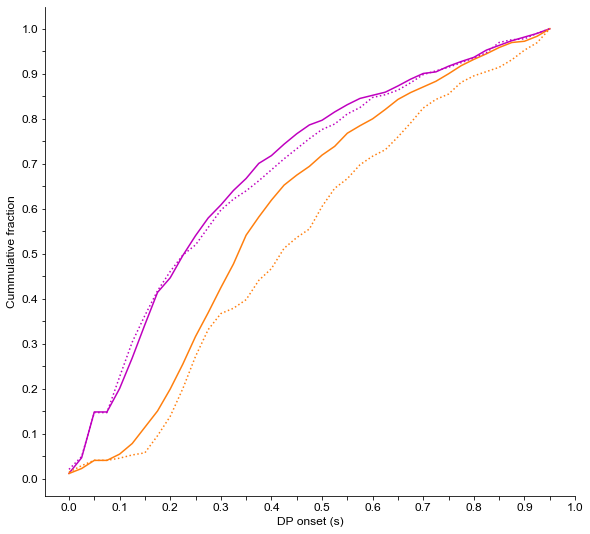

In [40]:
figure, ax = plt.subplots(1,1,figsize = (9.5, 9))

cumsum = cum_dist(dp_onsets['tac_dp_onset'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['tac_dp_onset'].dropna().shape, color = 'm')

cumsum = cum_dist(dp_onsets['vis_dp_onset'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['vis_dp_onset'].dropna().shape, color = 'C1')

cumsum = cum_dist(dp_onsets['tac_dp_onset_short'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['tac_dp_onset_short'].dropna().shape,':m')

cumsum = cum_dist(dp_onsets['vis_dp_onset_short'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['vis_dp_onset_short'].dropna().shape,':C1')


prettify_ax(ax, 'DP onset (s)', 'Cummulative fraction')

ticks = np.arange(0,1.05,0.05)
ax.set_xticks(ticks)
ticks = np.round(ticks.copy(),2).astype(str)
ticks[1::2] = ''
ax.set_xticklabels(ticks)

ticks = np.arange(0,1.05,0.05)
ax.set_yticks(ticks)
ticks = np.round(ticks.copy(),2).astype(str)
ticks[1::2] = ''
ax.set_yticklabels(ticks)

figure.savefig('DP_onset_cum_dist_short_long.pdf', format = 'pdf', dpi = 900)

In [41]:
scipy.stats.ks_2samp(dp_onsets['tac_dp_onset'].dropna(), dp_onsets['vis_dp_onset'].dropna())

Ks_2sampResult(statistic=0.2636642092823205, pvalue=1.1102230246251565e-16)

In [42]:
scipy.stats.ks_2samp(dp_onsets['tac_dp_onset'].dropna(), dp_onsets['tac_dp_onset_short'].dropna())

Ks_2sampResult(statistic=0.03866357439694854, pvalue=0.7180194943917371)

In [43]:
scipy.stats.ks_2samp(dp_onsets['vis_dp_onset'].dropna(), dp_onsets['vis_dp_onset_short'].dropna())

Ks_2sampResult(statistic=0.15224849327770051, pvalue=7.779175967947971e-06)